In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import re
import random

In [2]:
import os
import glob

path = 'dataset\\cstyle_dataset\\'
all_files = glob.glob(os.path.join(path, "*.txt")) 

frames = []
for f in all_files:
    file_df = pd.read_csv(f, header=None, index_col=None, sep='\n', names=['text'], engine='python')
    labels = [f.replace(path+'jstor_', '').replace('.txt', '') for x in range(len(file_df))]
    file_df['label'] = labels
    frames.append(file_df)
    
df   = pd.concat(frames, axis=0, ignore_index=True)
df

,text,label
0,"[1]T., V. and Quinney, D. 1987. An Introductio...",acm-sig-proceedings
1,"[1]Pope, S.T. et al. 1995. Touched by Machine?...",acm-sig-proceedings
2,"[1]Sugihara, M. and Murota, K. 1982. A Note on...",acm-sig-proceedings
3,"[1]Franklin, J.N. et al. 1965. Monte Carlo Met...",acm-sig-proceedings
4,"[1]Kitchen, J. and Denbaly, M. 1987. Commodity...",acm-sig-proceedings
...,...,...
50098,"Freedman, Marcia, and James G. Scoville. “The ...",mla
50099,"Smoliar, Stephen W., and Deryck Cooke. “The La...",mla
50100,"L., Y. L., and F. M. Arscott. “Periodic Differ...",mla
50101,"Katz, Lawrence F. “Some Recent Developments in...",mla


In [17]:
df.label.unique()

array(['acm-sig-proceedings', 'american-chemical-society', 'apa',
       'chicago-author-date', 'harvard3', 'ieee', 'mla'], dtype=object)

In [3]:
'''Reduce word tokens to just the type of words/punctuation they are'''
# Add more granularity to words and numbers -- months and years
# separate short form and full spelling of months for possible differences in citation format


def token_transformer(sentence, add_noise=False):
    sentence = re.sub(r"\b[A-Z]\b", 'L', sentence) #uppercase letters
    sentence = re.sub(r"\b[a-z]\b", 'l', sentence) #lowercase letters
    if add_noise:
        sentence = re.sub(r'\b(January|February|March|April|May|June|July|August|September|October|November|December)\b', random.choices(['M',''], weights=[3,1])[0], sentence)
        sentence = re.sub(r'\b(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\b', random.choices(['m',''], weights=[3,1])[0], sentence)
#         x = random.choice(['.', '\"', ',', '\'', '(', ')', '[', ']'])
#         print(x)
#         sentence = re.sub(r"["+"{}]".format(re.escape(x)), random.choices([x, ''], weights=[1,1])[0], sentence)
    else:
        sentence = re.sub(r'\b(January|February|March|April|May|June|July|August|September|October|November|December)\b', 'M', sentence) #random.choices(['M',''], weights=[3,1])[0], sentence)
        sentence = re.sub(r'\b(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\b', 'm', sentence) #random.choices(['m',''], weights=[3,1])[0], sentence)
    sentence = re.sub(r"\b[a-z][a-z]+\b", 'w', sentence) #lowercase words
    sentence = re.sub(r"\b[A-Z][a-z]+\b", 'W', sentence) #uppercase words
    sentence = re.sub(r'\b(1\d{3}|20[012]\d)\b', 'y', sentence)
    sentence = re.sub(r"\b[0-9]+\b", 'n', sentence) #numbers
    return sentence

def token_punctuation(sentence, add_noise=False):
    if add_noise:
        words = sentence.split()
        newSentence = []
        for word in words: # for every word with punctuation, there is a 10% chance of omitting one type of punctuation.
            newSentence.append(word.translate({ord(i):" {} ".format(random.choices([i, ''], weights=[9,1])[0]) for i in ',.()[]:;\'\"-'}))
        sentence = " ".join(newSentence)
        return sentence
    
    else:
        return sentence.translate({ord(i):" {} ".format(i) for i in ',.()[]:;\'\"-'})
    

''' Preprocess text column -- separate symbols with spaces to preserve punctuation as tokens'''
def preprocess(df, add_noise=False): # text is a dataframe column
    df.text = df.text.apply(token_punctuation, add_noise)
    df.text = df.text.apply(token_transformer, add_noise)
    return df
df = preprocess(df, True) # boolean flag to add noise. For training purposes to be robust against noise.

In [4]:
'''Testing the noise adding function. random punctuations and months are omitted'''
for frame in frames:
    mutator = token_punctuation(frame.iloc[1][0], True)
    print(frame.iloc[1][0])
    print(mutator)
    print(token_transformer(mutator))

[1]Pope, S.T. et al. 1995. Touched by Machine?: Composition and Performance in the Digital Age. Computer Music Journal. 19, 3 (1995), 13.
 [ 1 ] Pope ,  S . T .  et al .  1995 .  Touched by Machine? :  Composition and Performance in the Digital Age .  Computer Music Journal .  19 ,  3  ( 1995 )  ,  13 . 
 [ n ] W ,  L . L .  w w .  y .  W w W? :  W w W w w W W .  W W W .  n ,  n  ( y )  ,  n . 
(1) Pope, S. T.; Rahn, J.; Cerana, C.; Katayose, H.; Pecquet, F.; Karpen, R. Computer Music Journal 1995, 19, 13.
 ( 1 )  Pope ,  S .  T .  ;  Rahn ,  J .  ;  Cerana ,  C .  ;  Katayose ,  H .  ;  Pecquet   F .    Karpen ,  R .  Computer Music Journal 1995 ,  19 ,  13 . 
 ( n )  W ,  L .  L .  ;  W ,  L .  ;  W ,  L .  ;  W ,  L .  ;  W   L .    W ,  L .  W W W y ,  n ,  n . 
Pope, S. T., Rahn, J., Cerana, C., Katayose, H., Pecquet, F., & Karpen, R. (1995). Touched by Machine?: Composition and Performance in the Digital Age. Computer Music Journal, 19(3), 13. doi:10.2307/3680650
Pope ,  S .  T .

In [5]:
'''Create dataset with "unknown" label by mixing up the tokens'''
def token_scrambler(sentence):
    ss = sentence.split()
    sentence = ' '.join(random.sample(ss, len(ss)))
    return sentence

'''Returns original dataframe with the new unknown data'''
def create_unknown(df):
    df_unknown = df.sample(frac=0.25)
    df_unknown.label = 'unknown'
    df_unknown.text = df_unknown.text.apply(token_scrambler)
    frames = [df, df_unknown]
    df_extended = pd.concat(frames, axis=0, ignore_index=True)
    return df_extended

    
df_extended = create_unknown(df)

In [6]:
df_extended

,text,label
0,"[ n ] L . , L . w W , L . y . W W w w W...",acm-sig-proceedings
1,"[ n ] W , L . L . w w . y . W w W? : W w...",acm-sig-proceedings
2,"[ n ] W , L . w W , L . y . L W w W’l W ...",acm-sig-proceedings
3,"[ n ] W , L . L . w w . y . W W W . W w ...",acm-sig-proceedings
4,"[ n ] W , L . w W , L . y . W W , W W ,...",acm-sig-proceedings
...,...,...
62624,", w . . . y W W . W ) . y [ m L W W ] n , W n ...",unknown
62625,"+ , w w , . //w n l l : W w . n L . ∞ W w - , ...",unknown
62626,"w w W n/n w W . ) . ( . L W W , W w W : , . n ...",unknown
62627,", n , w ; y . W W W L L , , . ) ( . n W W W n w W",unknown


In [6]:
''' Create training and test dataset'''
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.text, df.label, test_size=0.25, random_state=42)

In [7]:
print(y_train.value_counts())
print(y_test.value_counts())
print(type(y_test.value_counts()))

mla                          5513
chicago-author-date          5415
american-chemical-society    5400
ieee                         5361
apa                          5342
acm-sig-proceedings          5296
harvard3                     5250
Name: label, dtype: int64
harvard3                     1842
acm-sig-proceedings          1831
mla                          1819
apa                          1798
ieee                         1771
american-chemical-society    1740
chicago-author-date          1725
Name: label, dtype: int64
<class 'pandas.core.series.Series'>


In [8]:
''' Will try a few approaches to categorising citation styles.
    First will be a naive one -- take strings, get tfidf vectors, then feed into LR.
    Second will like the one in crossref -- just use the orthographic features.
    Open bracket, close bracket, open sqbracket, close sqbracket,
    number, capitalised word, word, uppercase letter, 
    fullstop/dot, comma, colon, semicolon, quotation marks'''
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, plot_confusion_matrix, confusion_matrix as cm
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ('features', TfidfVectorizer(lowercase=False, token_pattern=r"\S+")),
    ('scaler', StandardScaler(with_mean=False)),
    ('classifier', LogisticRegression(class_weight='balanced'))
])
params = {'features__ngram_range': [(1,3)],
    'classifier__C': [0.001],
         'classifier__max_iter': [500],}
gs = GridSearchCV(pipeline, params, refit=True, cv=2, scoring='f1_macro', verbose=10)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2; 1/1] START classifier__C=0.001, classifier__max_iter=500, features__ngram_range=(1, 3)
[CV 1/2; 1/1] END classifier__C=0.001, classifier__max_iter=500, features__ngram_range=(1, 3); total time=  10.2s
[CV 2/2; 1/1] START classifier__C=0.001, classifier__max_iter=500, features__ngram_range=(1, 3)
[CV 2/2; 1/1] END classifier__C=0.001, classifier__max_iter=500, features__ngram_range=(1, 3); total time=   6.5s
Test F1 score: 0.9963621014128475
[[1822    0    8    0    0    0    1]
 [   3 1737    0    0    0    0    0]
 [   5    0 1790    0    2    0    1]
 [   0    0    0 1720    0    0    5]
 [   5    0    5    0 1831    0    1]
 [   3    0    0    0    0 1767    1]
 [   1    0    0    5    0    0 1813]]


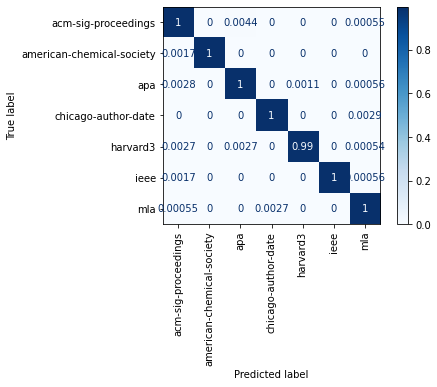

In [9]:
gs.fit(X_train, y_train)
y_pred = gs.predict(X_test)
score = f1_score(y_test, y_pred, average='macro')
cMtx = cm(y_test, y_pred)
print('Test F1 score: {}'.format(score))
print(cMtx)
plot_confusion_matrix(gs, X_test, y_test, normalize='true', cmap='Blues')
plt.xticks(rotation=90)
plt.show()

In [ ]:
pipeline.get_params().keys() # For parameter optimization

In [10]:
''' load the saved model '''
from joblib import dump
dump(gs.best_estimator_, 'models\\cstyle_LR_augmentedfeatures_3grams_noisyinput_noUnknown.pkl')


['models\\cstyle_LR_augmentedfeatures_3grams_noisyinput_noUnknown.pkl']

In [ ]:
'''Test with unseen texts from another subject matter'''

fpath = 'dataset\\jstor\\'
all_files = glob.glob(os.path.join(fpath, "unseen1000jstor_*.txt")) 
frames = []
for f in all_files:
    file_df = pd.read_csv(f, header=None, index_col=None, sep='\n', names=['text'], engine='python')
    labels = [f.replace(fpath+'unseen1000jstor_', '').replace('.txt', '') for x in range(len(file_df))]
    file_df['label'] = labels
    frames.append(file_df)

testdf   = pd.concat(frames, axis=0, ignore_index=True)
testdf = preprocess(testdf, True) # adding noise to test case. For actual use, might consider setting to false.
testdf_extended = create_unknown(testdf)

Test F1 score: 0.9979533815235956
[[895   0   0   0   0   0  12]
 [  0 907   0   0   0   0   0]
 [  0   0 906   0   0   0   1]
 [  0   0   0 907   0   0   0]
 [  0   0   0   0 907   0   0]
 [  0   0   0   0   0 907   0]
 [  0   0   0   0   0   0 907]]


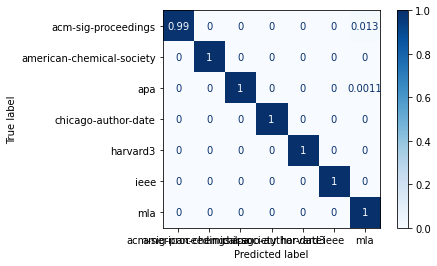

In [15]:
from joblib import load

# gs = load('models\\cstyle_LR_punctuations.pkl')
y_unseen = gs.predict(testdf.text)
score = f1_score(testdf.label, y_unseen, average='macro')
cMtx = cm(testdf.label, y_unseen)
print('Test F1 score: {}'.format(score))
print(cMtx)
plot_confusion_matrix(gs, testdf.text, testdf.label, normalize='true', cmap='Blues')
plt.show()

In [20]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder().fit(df_extended.label)
y_transformed = enc.transform(df_extended.label)
df_extended['labels_cat'] = y_transformed

In [22]:
df_extended

,text,label,labels_cat
0,"[ n ] L . , L . w W , L . y . W W w w W...",acm-sig-proceedings,0
1,"[ n ] W , L . L . w w . y . W w W? : W w...",acm-sig-proceedings,0
2,"[ n ] W , L . w W , L . y . L W w W’l W ...",acm-sig-proceedings,0
3,"[ n ] W , L . L . w w . y . W W W . W w ...",acm-sig-proceedings,0
4,"[ n ] W , L . w W , L . y . W W , W W ,...",acm-sig-proceedings,0
...,...,...,...
62624,", w . . . y W W . W ) . y [ m L W W ] n , W n ...",unknown,7
62625,"+ , w w , . //w n l l : W w . n L . ∞ W w - , ...",unknown,7
62626,"w w W n/n w W . ) . ( . L W W , W w W : , . n ...",unknown,7
62627,", n , w ; y . W W W L L , , . ) ( . n W W W n w W",unknown,7


In [36]:
from sklearn.preprocessing import OneHotEncoder
# c_style = df_extended.label.unique()
predictedlabels = gs.predict(testdf.text)
pred = list(map(lambda x:[x], predictedlabels))
categories = [['acm-sig-proceedings'], ['american-chemical-society'], ['apa'],
       ['chicago-author-date'], ['harvard3'], ['ieee'], ['mla']]

feature_style = OneHotEncoder(handle_unknown='ignore')
feature_style.fit(pred)
# feature_style = enc.transform(y_transformed)

OneHotEncoder(handle_unknown='ignore')

In [32]:
df_pred = pd.DataFrame(predictedlabels)
feat = df_pred.apply(lambda x: feature_style.transform)

In [38]:
feat = feature_style.transform(pred)